In [4]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 55.6 MB/s eta 0:00:00


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [6]:
from qutip import *
import random
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [7]:
random.seed(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# time = 1 -> GHz and ns
# time = 1000 -> MHz and us
time = 1
# spin flip, from chiyuan, pulse length is ns scale
# vac2cat, from chiyuan, pulse length is ms scale
g = 0.05*2*np.pi *time # cavity qubit coupling strength
N = 16 # Fock space truncation
wr = 1.0*2*np.pi *time# resonator frequency
Ez = 0.22*2*np.pi *time# qubit anharmonicity
chi = 0.007 *time # qubit-cavity coupling strength

# Number of time slots
n_ts = 100_000
# Time allowed for the evolution
evo_time = 5_000

# Fidelity error target
fid_err_targ = 1e-8
# Maximum iterations for the optisation algorithm
max_iter = 10000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 21600

# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
# for GRAPE, this is initial pulse type
p_type = 'SINE'

# Set to None to suppress output files
# f_ext = "{}_n_ts{}_ptype{}.txt".format('v2cat', n_ts, p_type)
f_ext = None

#### set up the operators ####
a = tensor(destroy(N),  qeye(2))
n_cavity = tensor(num(N), qeye(2))
Sigmaz = tensor(qeye(N),sigmaz())
Sigmax = tensor(qeye(N),sigmax())
Sigmam = tensor(qeye(N),  destroy(2))
Id = tensor(qeye(N),  qeye(2))
Sigmap = Sigmam.dag()

# H_d = wr * n_cavity + Ez * Sigmaz + chi * Sigmaz * (n_cavity + Id/2)
# corrected:
H_d = wr * n_cavity + Ez/2 * Sigmaz - chi * Sigmaz * (n_cavity + Id/2 )

H_c = [a + a.dag(),
       -1j*(a - a.dag()),
       Sigmax]


#### set Hamiltonian ####
n_ctrls = len(H_c)

H_labels = [r'$ReD$',
            r'$ImD2$',
            r'$R$']

#### initial and target states ####
alpha = np.sqrt(1) # coherent state complex amplitude

# vacuum to cat
psi_0 = tensor(fock(N, 0), basis(2, 0))
psi_targ = tensor((coherent(N, alpha)+coherent(N, -alpha)).unit(),  basis(2, 0))

# unselective spin rotation
# psi_0 = tensor(fock(N, 0), basis(2, 0))
# psi_targ = tensor(fock(N, 0), basis(2, 1))

# selective spin flip
# psi_0 = (tensor(fock(N, 1), basis(2, 0)) + tensor(fock(N, 0), basis(2, 0))).unit()
# psi_targ = (tensor(fock(N, 1), basis(2, 0)) + tensor(fock(N, 0), basis(2, 1))).unit() # selective wrt cavity state
U = psi_targ * psi_0.dag()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Run the optimisation

In [9]:
# GRAPE
result = cpo.optimize_pulse_unitary(H_d, H_c, Id, U,
                n_ts, evo_time,
                fid_err_targ=fid_err_targ,
                max_iter=max_iter, max_wall_time=max_wall_time,
                method_params={'xtol':1e-3},
                init_pulse_type=p_type,
                out_file_ext=f_ext,
                log_level=log_level, gen_stats=True)

# result  = cpo.optimize_pulse_unitary(H_d, H_c, U_0, U_targ,
#                                      num_tslots=None, evo_time=None, tau=None, amp_lbound=None, amp_ubound=None,
#                                      fid_err_targ=1e-10, min_grad=1e-10, max_iter=500, max_wall_time=180,
#                                      alg='GRAPE', alg_params=None, optim_params=None, optim_method='DEF', method_params=None,
#                                      optim_alg=None, max_metric_corr=None, accuracy_factor=None, phase_option='PSU',
#                                      dyn_params=None, prop_params=None, fid_params=None,
#                                      tslot_type='DEF', tslot_params=None, amp_update_mode=None,
#                                      init_pulse_type='DEF', init_pulse_params=None, pulse_scaling=1.0, pulse_offset=0.0,
#                                      ramping_pulse_type=None, ramping_pulse_params=None, log_level=0, out_file_ext=None, gen_stats=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[16, 2], [16, 2]], shape = (32, 32), type = oper, isherm = True
Qobj data =
[[ 0.68765038  0.          0.         ...  0.          0.
   0. 

In [10]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 2:43:37.551315
Wall time computing Hamiltonians: 0:04:31.724892 (2.77%)
Wall time computing propagators: 2:11:10.661753 (80.17%)
Wall time computing forward propagation: 0:03:16.052084 (2.00%)
Wall time computing onward propagation: 0:03:19.553679 (2.03%)
Wall time computing gradient: 0:20:39.545920 (12.63%)

**** Iterations and function calls ****
Number of iterations: 103
Number of fidelity function calls: 110
Number of times fidelity is computed: 110
Number of gradient function calls: 110
Number of times gradients are computed: 110
Number of times timeslot evolution is recomputed: 110

**** Control amplitudes ****
Number of control amplitude updates: 109
Mean number of updates per iteration: 1.058252427184466
Number of timeslot values changed: 10900000
Mean number of timeslot changes per update: 100000.0
Number of amplitude values ch

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def plot_amp(result,i):
    # i is the index of the control amplitude
    plt.figure(figsize=(5, 2))
    # title and labels
    plt.title("Control Amplitudes")
    plt.xlabel("Time $ns$")
    plt.ylabel("Control Amplitude $GHz$")

    # Plot the initial control amplitudes in blue
    plt.step(result.time,
             np.hstack((result.initial_amps[:, i], result.initial_amps[-1, i])),
             where='post',alpha = 0.7, label='Initial Amplitude')

    # Plot the final control amplitudes in red
    plt.step(result.time,
             np.hstack((result.final_amps[:, i], result.final_amps[-1, i])),
             where='post', color='red',alpha = 0.7, label='Final Amplitude')

    # Add a legend to the plot
    plt.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


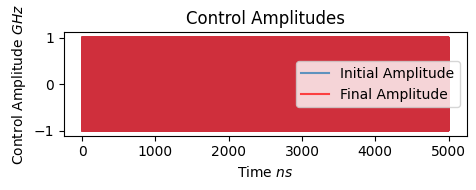

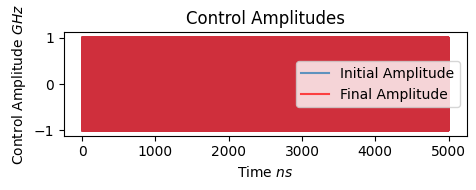

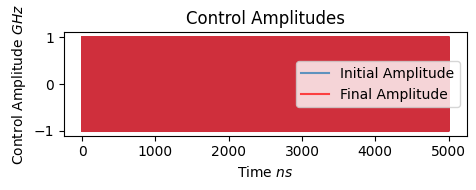

In [12]:
plot_amp(result,0)
plot_amp(result,1)
plot_amp(result,2)

In [13]:
def cavityFidelity(psi1, psi2):
    '''
    psi1, psi2: Qobj
    '''
    return fidelity(ptrace(psi1, 0), ptrace(psi2, 0))

def qubitFidelity(psi1, psi2):
    '''
    psi1, psi2: Qobj
    '''
    return fidelity(ptrace(psi1, 1), ptrace(psi2, 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


sesolve final fidelity:  0.4390558062780975
cavity ptrace fidelity:  0.44320315443027297
qubit ptrace fidelity:  0.9871678390509413
self-implemented final fidelity:  0.9529111010142354


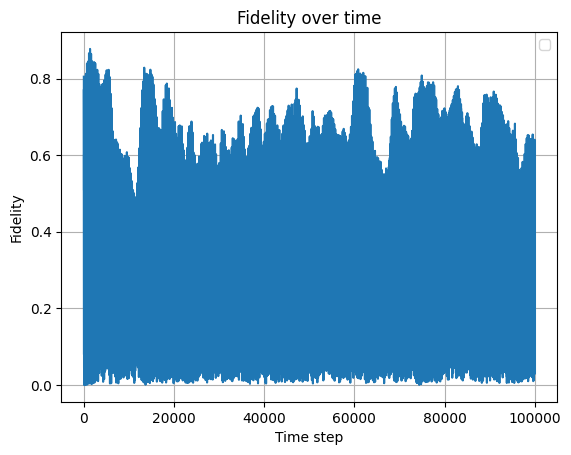

In [14]:
# H_c amplitudes (from pulse optimization)
amplitudes_0 = result.final_amps[:, 0]
amplitudes_1 = result.final_amps[:, 1]
amplitudes_2 = result.final_amps[:, 2]


tlist = np.linspace(0, evo_time, n_ts)
H_array_form =QobjEvo([H_d, [H_c[0], amplitudes_0], [H_c[1], amplitudes_1],[H_c[2], amplitudes_2]], tlist=tlist)

# res = qt.mesolve(H_array_form, psi_0, tlist)
res = sesolve(H_array_form, psi_0, tlist,options=Options(nsteps=1000000))


fidelities1 = []
for i in range(0, n_ts):
    fidelities1.append(qutip.metrics.fidelity(res.states[i].unit(), psi_targ.unit()))

print("sesolve final fidelity: ", fidelities1[-1])
# print(fidelities)
# times = np.arange(0,n_ts)
# plotting
# Create a new figure
plt.figure()

# Plot fidelities
plt.plot(fidelities1)
# plt.scatter(fidelities, marker='o')

# Set the title and labels for the plot
plt.title('Fidelity over time')
plt.xlabel('Time step')
plt.ylabel('Fidelity')
plt.legend()
plt.grid(True)

print('cavity ptrace fidelity: ', cavityFidelity(res.states[-1], psi_targ))
print('qubit ptrace fidelity: ', qubitFidelity(res.states[-1], psi_targ))

### self-implemented forward propagation ###
from scipy.linalg import expm

psi_init = psi_0.full()
psi_end = psi_targ.full()
fidelities = []
for n in range(len(tlist) - 1):
    H = H_d + sum([H_c[i] * result.final_amps[n, i] for i in range(n_ctrls)])
    H = H.full()
    dt = tlist[n + 1] - tlist[n]
    o = expm(-1j * H * dt)
    psi_init = np.matmul(o,psi_init)
    fid = np.abs(np.matmul(np.transpose(np.conjugate(psi_init)),psi_end))
    #
    fidelities.append(fid[0])
# print(shape(psi_init))

print("self-implemented final fidelity: ", fidelities[-1][0])




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


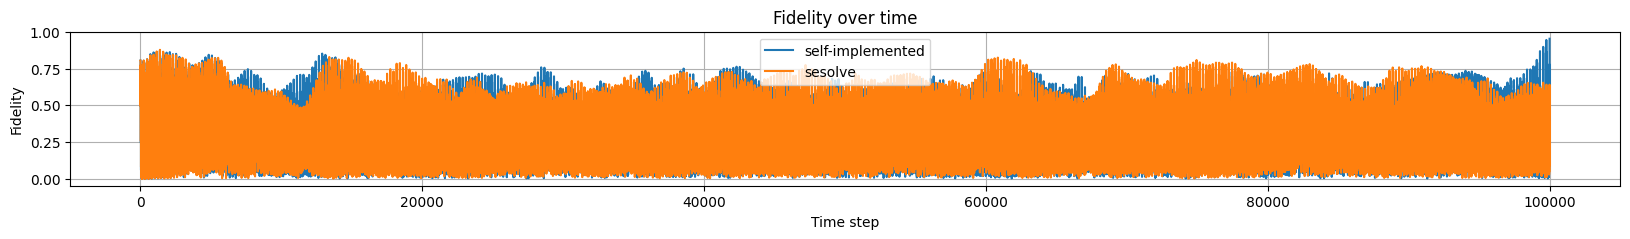

In [15]:
# Create a new figure
plt.figure(figsize=(20, 2))

# Plot fidelities
plt.plot(fidelities, label='self-implemented')
plt.plot(fidelities1, label='sesolve')

# Set the title and labels for the plot
plt.title('Fidelity over time')
plt.xlabel('Time step')
plt.ylabel('Fidelity')

# Add a legend
plt.legend()

plt.grid(True)
# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


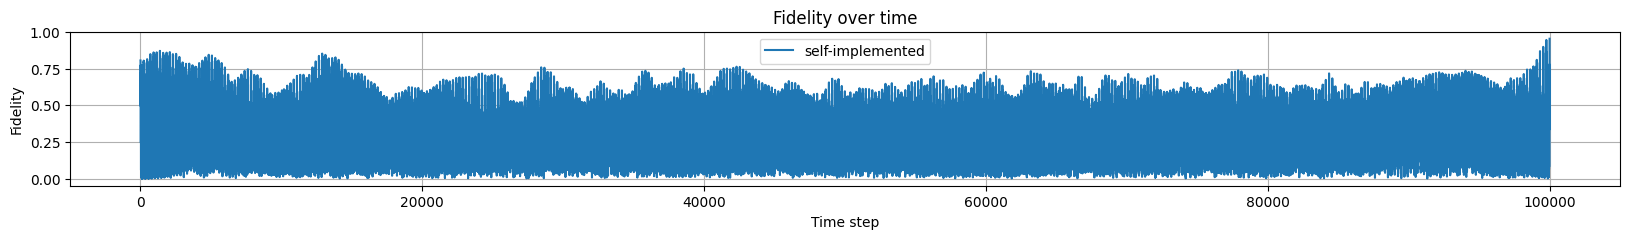

In [16]:
# Create a new figure
plt.figure(figsize=(20, 2))

# Plot fidelities
plt.plot(fidelities, label='self-implemented')
# plt.plot(fidelities1, label='sesolve')

# Set the title and labels for the plot
plt.title('Fidelity over time')
plt.xlabel('Time step')
plt.ylabel('Fidelity')

# Add a legend
plt.legend()

plt.grid(True)
# Show the plot
plt.show()